# Case 1: Predictive Analytics and Visualisations
In this notebook, there are the four main sections:
1. Import Data
2. Exploratory Data Analysis
    1. Dropping unnecessary columns
    2. Correlation matrix
    3. Checking for nans
    4. Describe payment type distributions
    5. Check for balance in label (isFraud column)
3. Feature engineering: Encoding
4. Models
    1. Logistic Regression
    2. Random Forrest

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, average_precision_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold

## Import Data

In [2]:
dirname = os.path.dirname('__file__')
filename = os.path.join(dirname, 'PS_20174392719_1491204439457_log.csv')
fraud_df = pd.read_csv(filename)

In [3]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Exploratory Data Analysis
1. Dropping unnecessary columns
    * Helps prevent your model from learning from noise (over-fitting)
2. Correlation Matrix
    * Check for colinearity
3. Check for nans
4. Describe Payment Type Distributions
    * There are 5 payment types.  We look at these distributions to check for skew (aka a large difference between the mean and median)
5. Balance in label (y value or isFraud column)
    * We want to check to make sure the number of 0 and 1 values in the isFraudulent column is around the same.  In a fraudulent transaction dataset we would expect there to be an imbalance, which we find to be true.
    * The challenenge with imbalanced datasets comes when you try to create test-train splits.  If you have an imbalance, a randomized test-train split could have messed up proportions between y-train and y-test.
    * We can solve this problem with a __stratified k-fold cross validation__.

### Dropping Unnecessary Columns

In [4]:
# Drop some useless columns
fraud_df = fraud_df.drop(['nameOrig','nameDest'], 1)
fraud_df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


### Correlation Matrix
We can see that there is a strong correlation between the oldbalanceOrg and newbalanceOrig.  This colinearity may hint to the fact that we will need to use Descision Trees for our classfication, which are immune to colinearity.  Another solution is to apply a PCA (principle component analysis) to the dataset before performing logistic regression. 

In [5]:
numeric_df = fraud_df[['amount','oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']]

rs = np.random.RandomState(0)
corr = numeric_df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000


### Checking for nans
There are no nans in this dataset

In [6]:
# Check for nans and entry counts
cols = fraud_df.columns

# Loop through columns to check for unique values and their respective counts as well as the number of nans
for val in cols:
    print(f"----------{val}----------")
    num_na = fraud_df[val].isna().sum()
    total_count = fraud_df[val].count().sum()
    percent = (num_na / total_count) * 100
    print("Percent nans:", percent, '%')
    print(fraud_df[val].value_counts(dropna=False))

----------step----------
Percent nans: 0.0 %
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: step, Length: 743, dtype: int64
----------type----------
Percent nans: 0.0 %
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
----------amount----------
Percent nans: 0.0 %
10000000.00    3207
10000.00         88
5000.00          79
15000.00         68
500.00           65
               ... 
91066.95          1
808.61            1
483714.88         1
775343.17         1
223098.05         1
Name: amount, Length: 5316900, dtype: int64
----------oldbalanceOrg----------
Percent nans: 0.0 %
0.00          2102449
184.00            918
133.00            914
195.00            912
164.00            909
               ...   
396813.93           1
189311.00           1
3355778.65          1
236757.00           1
102899.11          

### Describe Payment Type Distributions
__We ought to look into the distributions and skewness of each unique payment type, each of which has wildly different distributions.__

There are a total of 5 unique payment types in this dataset.

__In this dataset, outliers are considered signals, so we are not dropping outliers, despite there being a skew in all of the payment types.__

In [7]:
fraud_df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [8]:
payment_df = fraud_df.loc[fraud_df['type'] == 'PAYMENT'].drop(['step', 'isFraud', 'isFlaggedFraud', 'type'],1)
transfer_df = fraud_df.loc[fraud_df['type'] == 'TRANSFER'].drop(['step', 'isFraud', 'isFlaggedFraud','type'],1)
cash_out_df = fraud_df.loc[fraud_df['type'] == 'CASH_OUT'].drop(['step', 'isFraud', 'isFlaggedFraud','type'],1)
debit_df = fraud_df.loc[fraud_df['type'] == 'DEBIT'].drop(['step', 'isFraud', 'isFlaggedFraud','type'],1)
cash_in_df = fraud_df.loc[fraud_df['type'] == 'CASH_IN'].drop(['step', 'isFraud', 'isFlaggedFraud','type'],1)

#### Type = Payment

<AxesSubplot:>

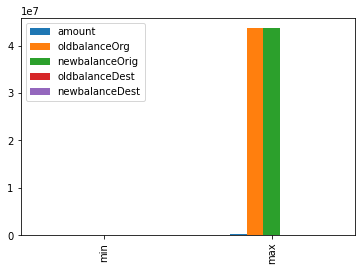

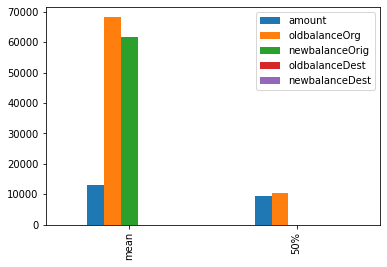

In [9]:
describe_payment_df = payment_df.describe()
min_max_values = describe_payment_df.loc[["min",'max']] 
median_mode_values = describe_payment_df.loc[["mean",'50%']] 
min_max_values.plot(kind = 'bar')
median_mode_values.plot(kind = 'bar')

#### Type = Transfer

<AxesSubplot:>

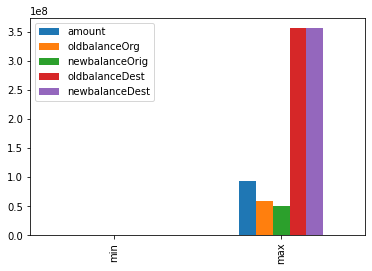

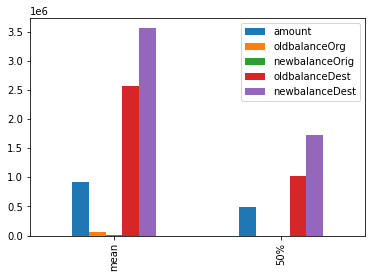

In [10]:
describe_transfer_df = transfer_df.describe()
min_max_values = describe_transfer_df.loc[["min",'max']] 
median_mode_values = describe_transfer_df.loc[["mean",'50%']] 
min_max_values.plot(kind = 'bar')
median_mode_values.plot(kind = 'bar')

#### Type = Cash Out

<AxesSubplot:>

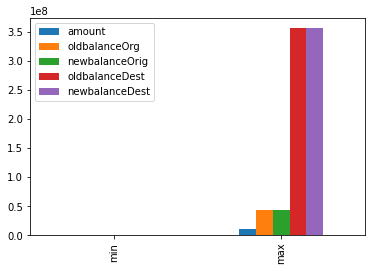

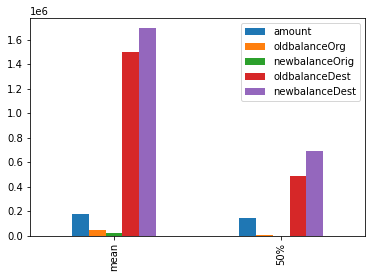

In [11]:
describe_cash_out_df = cash_out_df.describe()
min_max_values = describe_cash_out_df.loc[["min",'max']] 
median_mode_values = describe_cash_out_df.loc[["mean",'50%']] 
min_max_values.plot(kind = 'bar')
median_mode_values.plot(kind = 'bar')

#### Type = debit

<AxesSubplot:>

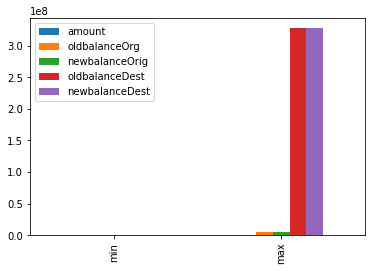

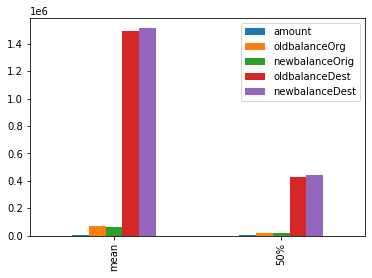

In [12]:
describe_debit_df = debit_df.describe()
min_max_values = describe_debit_df.loc[["min",'max']] 
median_mode_values = describe_debit_df.loc[["mean",'50%']] 
min_max_values.plot(kind = 'bar')
median_mode_values.plot(kind = 'bar')

#### Type = Cash-in

<AxesSubplot:>

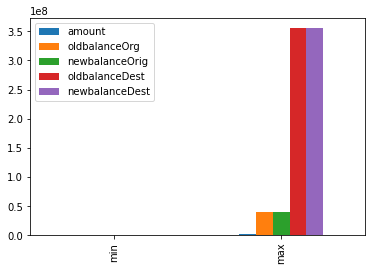

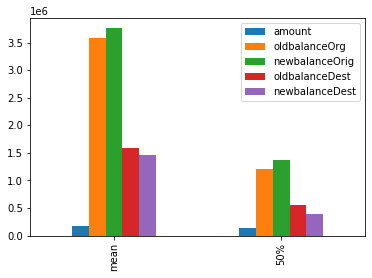

In [13]:
describe_cash_in_df = cash_in_df.describe()
min_max_values = describe_cash_in_df.loc[["min",'max']] 
median_mode_values = describe_cash_in_df.loc[["mean",'50%']] 
min_max_values.plot(kind = 'bar')
median_mode_values.plot(kind = 'bar')

### Balance in Label
I need to check to see whether I need to perform a stratified k-fold cross validation.  You usually need to do something like this if a random train-test split could end up creating a massive imbalance between the proportions of your y_train and y_test splits.  We clearly have an imbalance in this dataset, since there are 8213 known fraudulent transactions and 6354407 known non-fraudylent transactions.

In [14]:
fraud_df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

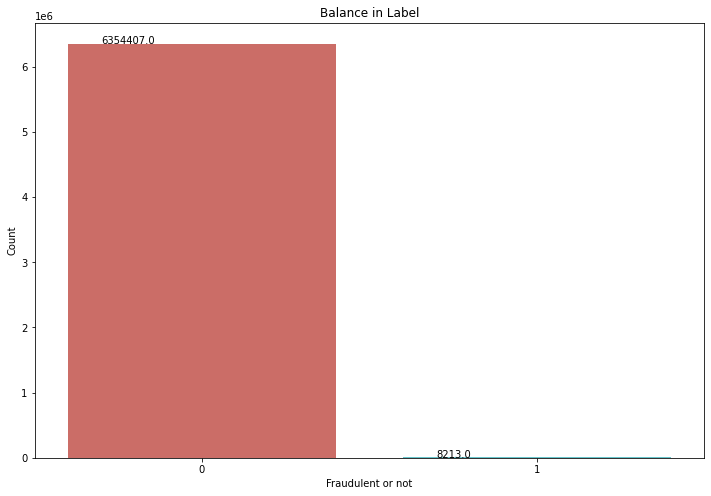

In [15]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x="isFraud", data=fraud_df, palette = 'hls')
plt.title('Balance in Label')
plt.xlabel('Fraudulent or not')
plt.ylabel('Count')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))


## Encoding
I am using one-hot encoding as apposed to dummy encoding since the payment type is not ordinal (order does not matter).

In [16]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(fraud_df['type'])
# Drop column B as it is now encoded
encoded_df = fraud_df.drop('type',axis = 1)
# Join the encoded df
encoded_df = encoded_df.join(one_hot)
encoded_df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,0,0,0,0,1


## Models
Since this is a highly imbalanced dataset, the accuracy score is not a good predictor of the model performance.  We do not want to misclassify fraudulent transactions so true negative rate should be low.  At the same time, we don't care about false possitive in the model.  If a non-fraudulent transaction is marked as fraudulent, the only cost on the company's behalf is a potential waste of time.  Recall reduces false-negatives and precision reduces false-positives.  Imbalanced dataset also require precision AUC curves, which we will be performing with both models.

I did not have the time for this assessment, but perhaps XGBoost would be best for this dataset because of hyperparameter opportunities with regularization for penalizing multi-colinearity.

I plotted prescision-recall curves since there is an imbalanced dataset as apposed to ROC AUC curves, which you usually use for balanced datasets.

1. Preparation of data using stratified k-fold cross validation since this is a higly imbalaned dataset with fewer 1s than 0s in the labels.  I am performing 2 splits with the StratifiedKFold.
2. I will be using the following classification algorithms for training the model as well as assessing their accuracies:
    1. Logistic Regresstion
        * Accuracy assessed with confusion matrix
    2. Random Forrest
        * This model actually performed satisfactorily, but the results can only be trusted with further hyperparameter tuning and using algorithms such as XGBoost.

--------------------------
Logistic Regression
--------------------------
[[3166619   10585]
 [    975    3131]]


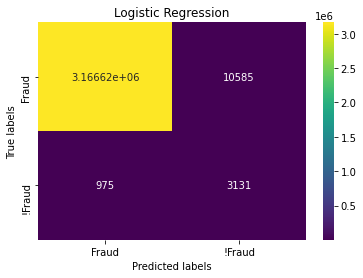

--------------------------
Random forest classifier
--------------------------
[[3177070     134]
 [    981    3125]]


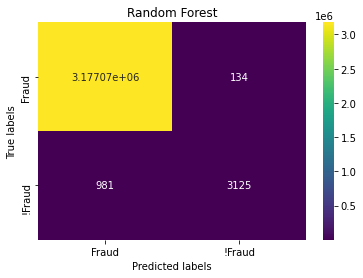

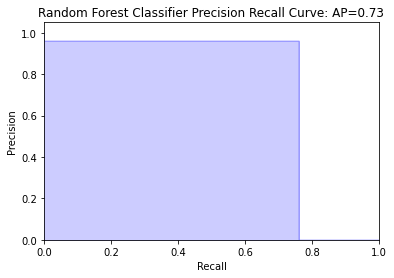

--------------------------
Logistic Regression
--------------------------
[[3172979    4224]
 [    777    3330]]


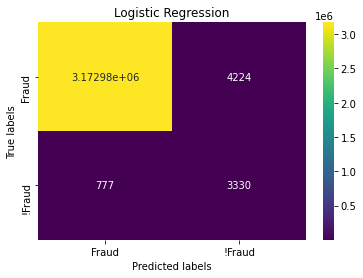

--------------------------
Random forest classifier
--------------------------
[[3177110      93]
 [    914    3193]]


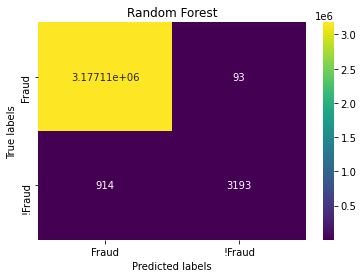

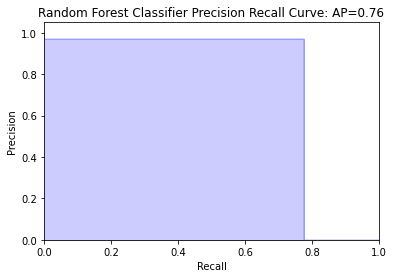

In [17]:
# Create X and y variables
X = encoded_df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest',
                'newbalanceDest','isFlaggedFraud','CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER']]
y = encoded_df['isFraud']
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)

# Create model objects
lr = LogisticRegression(random_state=0, solver='liblinear', max_iter=1500)
rfmodel = RandomForestClassifier()

# Perform a stratified k-fold cross validation 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    
    #########################################
    #Logistic regression
    #########################################
    print("--------------------------")
    print("Logistic Regression")
    print("--------------------------")
    lrmodel = lr.fit(X_train, Y_train.values.reshape(-1,))
    Y_predict_lr = lrmodel.predict(X_test)

    accuracyscore = accuracy_score(Y_test.values, Y_predict_lr)
    recallscore = recall_score(Y_test.values, Y_predict_lr)
    avgprecisionscore = average_precision_score(Y_test.values, Y_predict_lr)
    f1score = f1_score(Y_test.values, Y_predict_lr, average = None)

    data = [['Accuracy Score', accuracyscore, 'Logistic Regression'], 
            ['Recall Score', recallscore, 'Logistic Regression'], 
            ['Average precision Score', avgprecisionscore, 'Logistic Regression'],
            ['F1 Score', f1score, 'Logistic Regression']] 
    # Create the pandas DataFrame 
    dflr = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 
    

    cm = confusion_matrix(Y_test, Y_predict_lr)
    print(cm)
    #Plot the confusion matrix
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g'); 
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels'); 
    ax.set_title('Logistic Regression'); 
    ax.xaxis.set_ticklabels(['Fraud', '!Fraud']); 
    ax.yaxis.set_ticklabels(['Fraud', '!Fraud']);
    plt.show()

    #########################################
    #Random forest classifier
    #########################################
    print("--------------------------")
    print("Random forest classifier")
    print("--------------------------")
    rfmodel.fit(X_train, Y_train.values.reshape(-1,))
    Y_predict_rf = rfmodel.predict(X_test)
    #print("Accuracy score: ", rfmodel.score(X_test, Y_test))
    accuracyscore = accuracy_score(Y_test.values, Y_predict_rf)
    recallscore = recall_score(Y_test.values, Y_predict_rf)
    avgprecisionscore = average_precision_score(Y_test.values, Y_predict_rf)
    f1score = f1_score(Y_test.values, Y_predict_rf, average = None)

    data = [['Accuracy Score', accuracyscore, 'Random Forest Classifier'], 
            ['Recall Score', recallscore, 'Random Forest Classifier'], 
            ['Average precision Score', avgprecisionscore, 'Random Forest Classifier'],
            ['F1 Score', f1score, 'Random Forest Classifier']] 
    # Create the pandas DataFrame 
    dfrf = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

    cm = confusion_matrix(Y_test, Y_predict_rf)
    print(cm)
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Random Forest'); 
    ax.xaxis.set_ticklabels(['Fraud', '!Fraud']); 
    ax.yaxis.set_ticklabels(['Fraud', '!Fraud']);
    plt.show()

    # Precision Recall Curve
    precision, recall, threshold = precision_recall_curve(Y_test, Y_predict_rf)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Random Forest Classifier Precision Recall Curve: AP={0:0.2f}'.format(avgprecisionscore))
    plt.show()